# Telegram username - @polotens

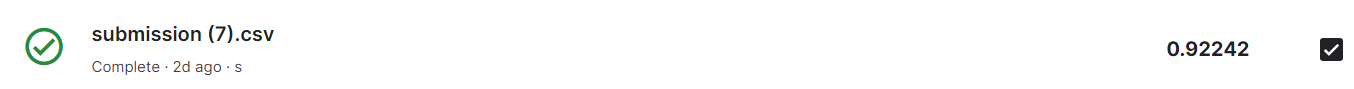

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.3 MB/s eta 0:00:44tcmalloc: large alloc 1147494400 bytes == 0x65732000 @  0x7fbc6989b615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 7.0 kB/s 
     |████████████████████████████████| 24.3 MB 72.9 MB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
     |████████████████████████████████| 849 kB 59.7 MB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 317.1 MB 34 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uni

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow==5.3.0 #если не будет работать раскоментировать
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/

MyDrive


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip


-rw------- 1 root root 546224286 Nov  6 09:21 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls -1

characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train


In [ ]:
!ls train

simpsons_dataset


In [ ]:
!ls train
!ls testset

simpsons_dataset
testset


In [ ]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [ ]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Tue Nov 15 13:27:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
"""очень долго не мог нормальнл импортировать библиотеки, 
скорее всего ошибка в несовместимостях версий торча
просто нудн скачать PIL версии 5.3.0
"""
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

import torch
import torchvision
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import pandas as pd
from matplotlib import colors, pyplot as plt
import seaborn as sns
import math
from PIL import Image
import random
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, transform = None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        # Датасет у нас хранится в виде некоторых картинок, но как только мы достаем из него элемент с ним делается __getitem__
        transform = self.transform
        if transform is None:
            transform = transforms.Compose([
            transforms.ToTensor(),      # кстати totensor приводит итак все величины к от 0 до 1
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # видимо по каждому каналу уже были посчитаны
            ])

        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

In [ ]:
def save_to_kaggle(model, test_dataset, output_path = './submission.csv'):
  """
  function to save submission on kaggle
  """
  test_dataset = SimpsonsDataset(test_files, mode="test")
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

  test_filenames = [path.name for path in test_dataset.files]
  my_submit = pd.DataFrame()
  my_submit['Id'] = test_filenames
  my_submit['Expected'] = preds
  my_submit.to_csv(output_path, index=False)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

In [ ]:
data = get_count(train_val_labels)


In [ ]:
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()

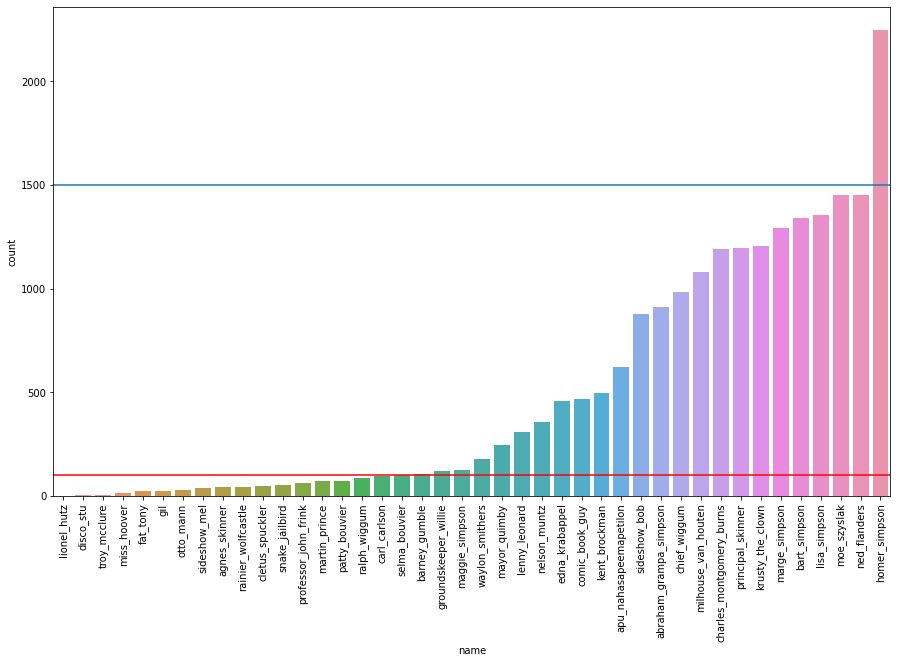

In [ ]:
show_data(data)

Data is unbalanced, we should augment our dataset

In [ ]:
data['to_add'] = data['count'].apply(lambda x: 1500 - x if x < 1500 else 0)
data['one_iteration'] = data.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
data

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55
gil,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1)
}

In [ ]:
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = load_image(image_path)
    # if we don't need to add any images, we can continue without transformation
    if data.loc[character]['to_add'] <= 0:
        continue

    # if number of images to create for one iteration is greater than the rest of images to create,
    # we should use 'to_add' instead of 'one_iteration'  
    if data.loc[character]['one_iteration'] > data.loc[character]['to_add']:
        iter_size = data.loc[character]['to_add']
    else:
        iter_size = data.loc[character]['one_iteration']
    data.loc[character]['to_add'] -= iter_size
    
    for i in range(iter_size):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

100%|██████████| 20933/20933 [06:36<00:00, 52.77it/s]


In [ ]:
!zip -r "journey-springfield-augmented.zip" . > /dev/null

In [ ]:
aug_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)

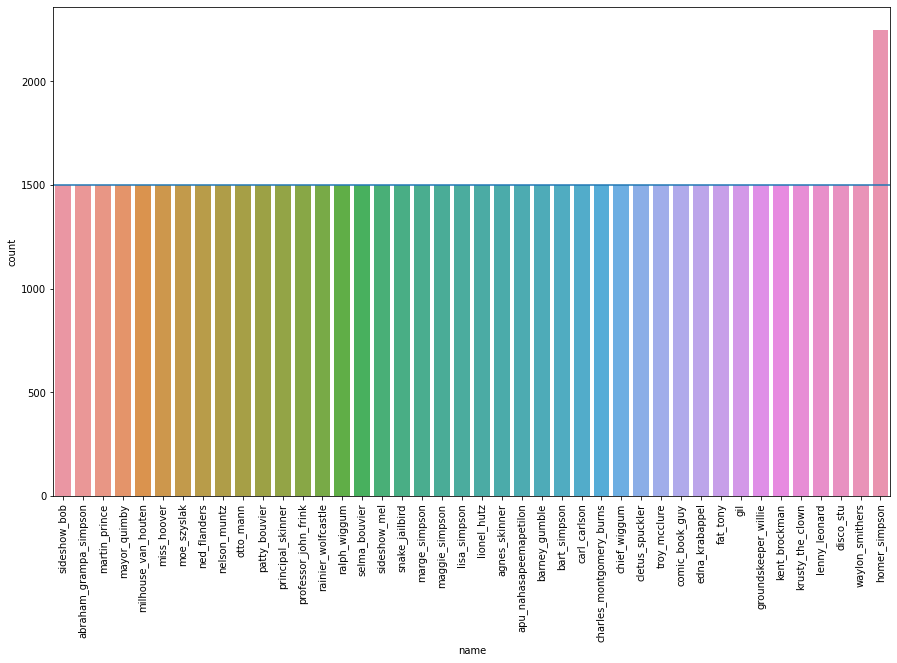

In [ ]:
show_data(aug_data, min_level=False)

In [ ]:
len(aug_files)

63745

In [ ]:
train_val_labels = [path.parent.name for path in aug_files]
train_files, val_files = train_test_split(aug_files, test_size=0.25, \
                                          stratify=train_val_labels)
print(f'Length of training dataset is {len(train_files)}')
print(f'Length of validation dataset is {len(val_files)}')

Length of training dataset is 47808
Length of validation dataset is 15937


In [ ]:
train_dataset = SimpsonsDataset(train_files, mode = 'train')
val_dataset = SimpsonsDataset(val_files, mode = 'val')


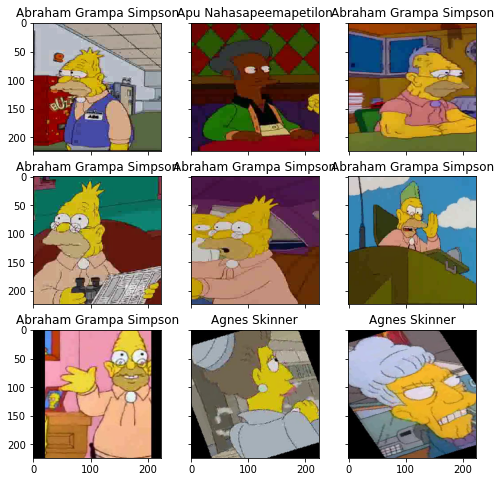

In [ ]:
from PIL import Image


def show_random_images(dataset):

  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
  for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

show_random_images(val_dataset)

**Expand dataset with augmented image**

Давайте посмотрим на наших героев внутри датасета.

In [ ]:
def show_random_images(dataset):
  from PIL import Image

  fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
  for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

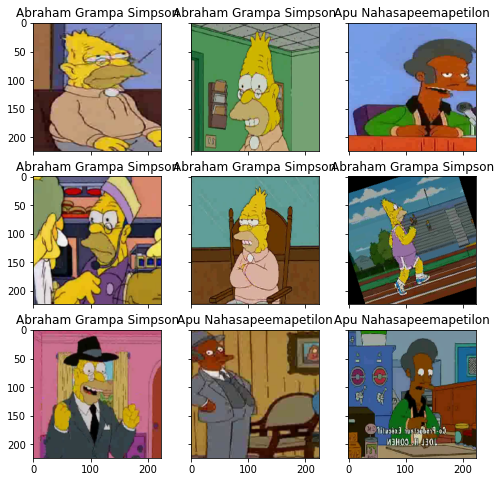

In [ ]:
from PIL import Image

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

In [2]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [3]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [4]:
def train(train_files, val_files, model, epochs, batch_size, opt, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        scheduler = scheduler
        opt = opt
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()
            
    return history

In [5]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

Построим кривые обучения

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
from torchvision import models

In [ ]:
def initialise_model(model_name, num_classes, tune_conv_layer = False, use_pretrained=True):
  model_ft = None
  
  if model_name == 'resnet':
    """
    ResNet18
    """
    
    model_ft = models.resnet18(pretrained = use_pretrained)
    for param in model_ft.parameters():
      param.requires_grad = False
    num_features = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_features, num_classes)
    input_size = 224

  if model_name == 'alexnet':
    """
    AlexNet
    """
    model_ft = models.alexnet(pretrained = use_pretrained)
    for param in model_ft.parameters():
      param.requires_grad = False
    num_features = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_features,num_classes)
    nput_size = 224
  if model_name == 'densenet':
    """
    DenseNet
    """

    model_ft = models.densenet121(pretrained = use_pretrained)
    for param in model_ft.parameters():
      param.requires_grad = False
    num_features = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_features, num_classes)
  
  return model_ft

# VGG-16

In [ ]:
from functools import partial
from torch.nn import functional as F

model_conv = torchvision.models.vgg16_bn(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_classes = len(np.unique(train_val_labels))
model_conv.classifier = nn.Linear(512 * 7 * 7, num_classes)
model_conv = model_conv.to('cuda')

criterion = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.AdamW(model_conv.parameters(), lr=1e-3, amsgrad=True)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.007634234651936426


epoch:  50%|█████     | 1/2 [11:21<11:21, 681.86s/it]


Epoch 001 train_loss: 0.0076     val_loss 0.1765 train_acc 0.9998 val_acc 0.9534
loss 0.003640446544174788


epoch: 100%|██████████| 2/2 [22:30<00:00, 675.13s/it]


Epoch 002 train_loss: 0.0036     val_loss 0.1722 train_acc 1.0000 val_acc 0.9558


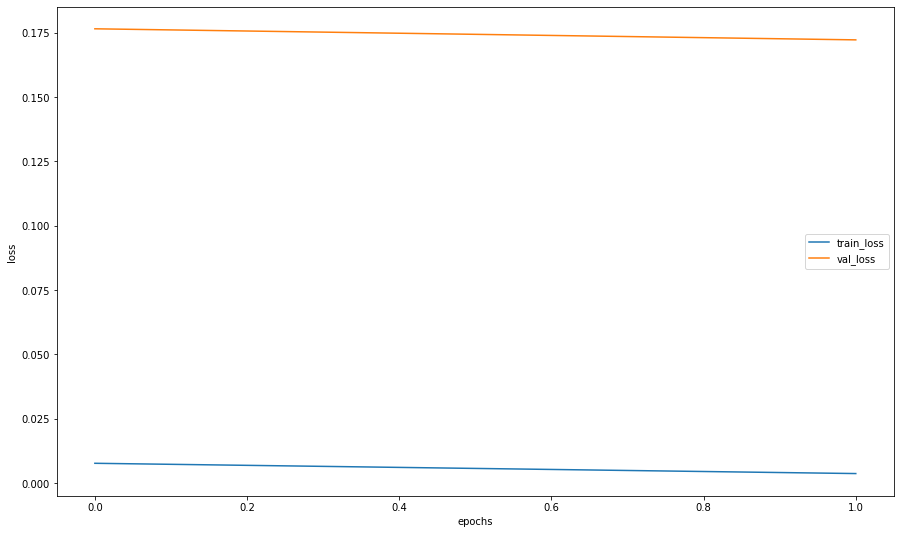

In [ ]:
history = train(train_dataset, val_dataset,model_conv,epochs=2, opt = optimizer_ft, scheduler = exp_lr_scheduler, batch_size = 32)
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


**Save to kaggle**

In [ ]:
import pandas as pd
def save_to_kaggle(model, test_dataset, output_path = './submission.csv'):
  test_dataset = SimpsonsDataset(test_files, mode="test")
  test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
  probs = predict(model, test_loader)
  preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

  test_filenames = [path.name for path in test_dataset.files]
  my_submit = pd.DataFrame()
  my_submit['Id'] = test_filenames
  my_submit['Expected'] = preds
  my_submit.to_csv(output_path, index=False)

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
